# アミノ酸配列のグラフ表示画像のTransformerによるタンパク質ファミリー分類

## 1. 画像とラベルの対応を取る `Dataset` を作成

In [1]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

import os

label2id = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
id2label = {v: k for k, v in label2id.items()}

class GPCRImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path, header=None, names=["num", "label", "accession"])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['num']}.png")
        image = Image.open(img_path).convert("RGB")
        label = label2id[row["label"]]

        if self.transform:
            image = self.transform(image)

        return {
            "pixel_values": image,
            "label": label
        }

## 2. 画像前処理（ViT用）

In [4]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
# from transformers import AutoImageProcessor
from transformers import ViTImageProcessorFast

processor = ViTImageProcessorFast.from_pretrained("google/vit-base-patch16-224-in21k")
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

## 3. ViTモデルの準備

In [5]:
# from transformers import AutoModelForImageClassification
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=5,
    id2label=id2label,
    label2id=label2id
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. `Trainer` を使って学習

In [13]:
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./vit-gpcr",
    per_device_train_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=20,
    logging_dir="./logs",
    report_to="none"
)

In [14]:
from torch.utils.data import random_split

dataset = GPCRImageDataset("gpcr_labels.csv", "./graphs", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, eval_ds = random_split(dataset, [train_size, val_size])

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

trainer.train()  # 学習

C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_37688\1133778327.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.045695,0.988990
2,No log,0.043663,0.987047
3,No log,0.055463,0.986399
4,No log,0.041327,0.990285
5,No log,0.046440,0.989637
6,0.032600,0.082145,0.980570
7,0.032600,0.054933,0.988342
8,0.032600,0.053973,0.985751
9,0.032600,0.043728,0.990285
10,0.032600,0.049267,0.989637


TrainOutput(global_step=1940, training_loss=0.016316788466935305, metrics={'train_runtime': 20365.6042, 'train_samples_per_second': 6.061, 'train_steps_per_second': 0.095, 'total_flos': 9.565868398667858e+18, 'train_loss': 0.016316788466935305, 'epoch': 20.0})

## 5. ログを残す

In [15]:
for log in trainer.state.log_history:
    print(log)

{'eval_loss': 0.045695431530475616, 'eval_accuracy': 0.9889896373056994, 'eval_runtime': 48.3552, 'eval_samples_per_second': 31.93, 'eval_steps_per_second': 3.991, 'epoch': 1.0, 'step': 97}
{'eval_loss': 0.04366319254040718, 'eval_accuracy': 0.9870466321243523, 'eval_runtime': 48.3747, 'eval_samples_per_second': 31.918, 'eval_steps_per_second': 3.99, 'epoch': 2.0, 'step': 194}
{'eval_loss': 0.05546291172504425, 'eval_accuracy': 0.9863989637305699, 'eval_runtime': 47.6635, 'eval_samples_per_second': 32.394, 'eval_steps_per_second': 4.049, 'epoch': 3.0, 'step': 291}
{'eval_loss': 0.04132659360766411, 'eval_accuracy': 0.9902849740932642, 'eval_runtime': 47.3107, 'eval_samples_per_second': 32.635, 'eval_steps_per_second': 4.079, 'epoch': 4.0, 'step': 388}
{'eval_loss': 0.04644036665558815, 'eval_accuracy': 0.9896373056994818, 'eval_runtime': 48.1165, 'eval_samples_per_second': 32.089, 'eval_steps_per_second': 4.011, 'epoch': 5.0, 'step': 485}
{'loss': 0.0326, 'grad_norm': 0.087055675685405

## 6. 評価

### 6.1 全体評価

In [16]:
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.051760900765657425, 'eval_accuracy': 0.9896373056994818, 'eval_runtime': 69.5689, 'eval_samples_per_second': 22.194, 'eval_steps_per_second': 2.774, 'epoch': 20.0}


In [17]:
# 推論
preds = trainer.predict(eval_ds)

# 正解ラベルと予測ラベル
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

Weighted F1 Score: 0.9896226554610129
Confusion Matrix:
 [[1065    1    4    0    0]
 [   2   86    2    0    0]
 [   4    1  375    1    0]
 [   0    0    1    0    0]
 [   0    0    0    0    2]]


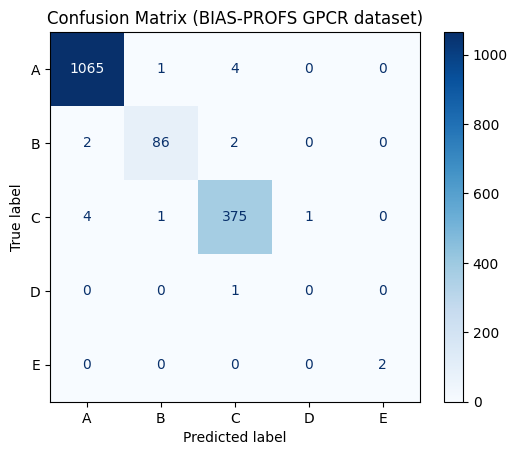

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay

# 混同行列
cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

print("Weighted F1 Score:", f1)
print("Confusion Matrix:\n", cm)

# 可視化
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (BIAS-PROFS GPCR dataset)")
plt.show()

### 6.2 クラスごとの評価

In [20]:
from sklearn.metrics import classification_report

# ラベル名リスト
target_names = list(label2id.keys())

# 各クラスごとの評価指標を出力
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print(report)

              precision    recall  f1-score   support

           A     0.9944    0.9953    0.9949      1070
           B     0.9773    0.9556    0.9663        90
           C     0.9817    0.9843    0.9830       381
           D     0.0000    0.0000    0.0000         1
           E     1.0000    1.0000    1.0000         2

    accuracy                         0.9896      1544
   macro avg     0.7907    0.7870    0.7888      1544
weighted avg     0.9896    0.9896    0.9896      1544

